<a href="https://colab.research.google.com/github/AlexWan0/PromotionalLSTM/blob/master/train_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Config**

In [0]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each sequence
MAX_SEQUENCE_LENGTH = 400

EMBEDDING_DIM = 100

BASE_DIR = "/content/gdrive/My Drive/articles_with_bias_data/"

EPOCHS = 5
BATCH_SIZE = 128

**Reading Data**

Imports

In [2]:
from google.colab import drive
import os
import urllib3
import pandas as pd
import csv
import sys
csv.field_size_limit(sys.maxsize)

131072

Intializing Google Drive

In [3]:
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Read Data

In [0]:
data = {'text': [], 'advert': [], 'resume': [], 'pr': [], 'coi': [], 'fanpov': [], 'promotion':[], 'negative': []}
label_map = {7}
def append_binary(labels):
  col_labels = ['advert', 'resume', 'pr', 'coi', 'fanpov', 'promotion', 'negative']
  for lbl in col_labels:
    if lbl in labels:
      data[lbl].append(1)
    else:
      data[lbl].append(0)

with open(os.path.join(BASE_DIR,'promotional.csv'), newline='') as f:
  reader = csv.reader(f)
  for row in reader:
    text = row[0]
    labels = row[1:]
    data['text'].append(text)
    if labels[0] == "previous":
      labels[0] == "negative"
    append_binary(labels)

with open(os.path.join(BASE_DIR,'good.csv'), newline='') as f:
  reader = csv.reader(f)
  for row in reader:
    text = row[0]
    data['text'].append(text)
    append_binary(['negative'])

df = pd.DataFrame(data)

Category Sizes

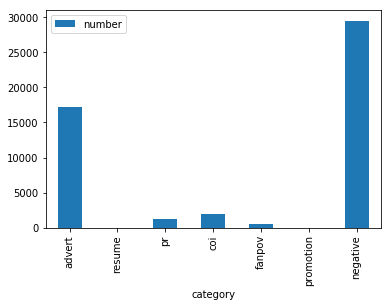

In [5]:
import matplotlib.pyplot as plt

df_cats = df.drop(['text'], axis=1)
counts = []
categories = list(df_cats.columns.values)
for i in categories:
    counts.append((i, df_cats[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number'])

df_stats.plot.bar(x='category')

#df_stats

Combining Promotional Categories

In [0]:
data_comb = {'text': [], 'label': []}
for index, row in df.iterrows():
  data_comb['text'].append(row['text'])
  if data['negative'][index] == 1:
    data_comb['label'].append(0)
  else:
    data_comb['label'].append(1)
df = pd.DataFrame(data_comb)

Text Lengths In Each Category

In [0]:
lengths = {'lens': [], 'labels': []}
for i, row in df.iterrows():
  word_count = len(row[0].split(" "))
  
  if word_count < MAX_SEQUENCE_LENGTH:
    df.drop(i)
  else:
    lengths['lens'].append(word_count)
    lengths['labels'].append(row[1])

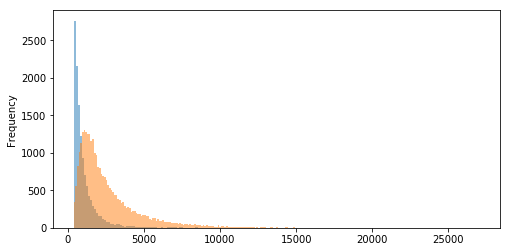

In [8]:
df_len = pd.DataFrame(lengths)
#df_len.hist()
df_len[df_len.labels == 1]["lens"].plot.hist(alpha=0.5, bins=200, figsize=(8,4))
df_len[df_len.labels == 0]["lens"].plot.hist(alpha=0.5, bins=200, figsize=(8,4))

**Model Training**

Imports

In [9]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, SpatialDropout1D, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
import datetime
import pickle
from sklearn.model_selection import train_test_split

# fix random seed for reproducibility
np.random.seed(4)

Using TensorFlow backend.


Shuffling Data

In [0]:
df = df.reindex(np.random.permutation(df.index))

Label to One-Hot

In [0]:
labels = pd.get_dummies(df['label'])

Tokenizing Text

In [12]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(df['text'].values)
X = sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Found 719328 unique tokens.
Shape of data tensor: (51012, 400)


Split Data

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state = 4)

Model Building

In [0]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(80, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model Training

In [20]:
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 36728 samples, validate on 4081 samples
Epoch 1/5
36728/36728 [==============================] - 417s 11ms/step - loss: 0.4074 - acc: 0.8273 - val_loss: 0.2877 - val_acc: 0.8986
Epoch 2/5
36728/36728 [==============================] - 411s 11ms/step - loss: 0.3056 - acc: 0.8798 - val_loss: 0.3040 - val_acc: 0.8905
Epoch 3/5
36728/36728 [==============================] - 409s 11ms/step - loss: 0.2611 - acc: 0.8948 - val_loss: 0.4763 - val_acc: 0.7839
Epoch 4/5
36728/36728 [==============================] - 409s 11ms/step - loss: 0.2059 - acc: 0.9243 - val_loss: 0.2868 - val_acc: 0.8966
Epoch 5/5
36728/36728 [==============================] - 407s 11ms/step - loss: 0.1349 - acc: 0.9524 - val_loss: 0.2872 - val_acc: 0.9081


Evaluating

In [21]:
eval_res = model.evaluate(x_test, y_test)
print(eval_res)

10203/10203 [==============================] - 24s 2ms/step
[0.2549155214236412, 0.9182593354895618]


Saving

In [22]:
timestamp = datetime.datetime.now().strftime("%H%M_%d%m%Y")

save_dir = os.path.join(BASE_DIR,timestamp)

os.makedirs(save_dir)

model_json = model.to_json()
with open(os.path.join(save_dir,"model.json"), "w") as json_file:
  json_file.write(model_json)

model.save_weights(os.path.join(save_dir,"model.h5"))

with open(os.path.join(save_dir,"tokenizer.pickle"), "wb") as tk_file:
  pickle.dump(tokenizer, tk_file, protocol=pickle.HIGHEST_PROTOCOL)
  
with open(os.path.join(save_dir,"config.txt"), "w") as config_file:
  config_file.write("MAX_SEQUENCE_LENGTH="+str(MAX_SEQUENCE_LENGTH))
  
with open(os.path.join(save_dir,"eval.txt"), "w") as eval_file:
  eval_file.write("Loss: %f, Accuracy: %f" % tuple(eval_res))

with open(os.path.join(save_dir,"history.pickle"), "wb") as history_file:
  pickle.dump(history, history_file)
  
print("Model data saved to", save_dir)

Model data saved to /content/gdrive/My Drive/articles_with_bias_data/1807_11052019


Testing

In [23]:
text = ["Oryzomys pliocaenicus is a fossil rodent from the Hemphillian late Miocene of Kansas central United States It is known from a single mandible lower jaw with the back part missing All three molars are present but very worn Together the molars are 3 6 mm long The fossil was discovered in 1935 and described in 1939 as a possible species of Oryzomys in open nomenclature Later authors doubted this allocation and suggested that it may instead belong in Bensonomys or Jacobsomys but the material may not allow a definite identification The only known specimen of Oryzomys pliocaenicus is a mandible lower jaw found in the spring of 1935 by David Dunkle in Edson Quarry Sherman County Kansas It is in the collections of the Museum of Comparative Zoology at Harvard University as specimen MCZ 6202 Edson Quarry is in the Ogallala Formation and the Hemphillian North American Land Mammal Age Claude W Hibbard described the mandible as Oryzomys pliocaenicus in a 1939 paper Hibbard wrote that the fauna was middle Pliocene but it is now considered Miocene The Edson Quarry fauna contains a diversity of other fossils including mammals birds reptiles and amphibians Oryzomys pliocaenicus is known from a single mandible with the incisor and three molars in it Much of the back of the jaw is missing including the angular condyloid and coronoid processes The mental foramen a foramen opening at the front of the jaw in the diastema between the incisor and molars opens upwards a little more so than in the living marsh rice rat Oryzomys palustris The masseteric ridges which anchor some of the chewing muscles and are located on the outer surface of the mandible are similar to those of Oryzomys The molars are very worn so that only traces of the cusps remain no accessory small cusps are visible Each of the teeth has two roots The length of the toothrow is 3 6 mm and the depth of the mandible below the first molar is also 3 6 mm Hibbard wrote that the condition of the mental foramen and masseteric ridges excluded the specimen from Onychomys Peromyscus Reithrodontomys and Eligmodontia and that in these features and in its depth and size the fossil more closely resembled Oryzomys therefore he placed it in that genus with a query Oryzomys is a living genus that has occurred in the United States since at least 300 000 years ago In 1966 Philip Hershkovitz wrote that Hibbard had reconsidered his opinion after re examining O pliocaenicus in 1952 he no longer thought that it was an Oryzomys and instead believed it may be a Bensonomys The latter genus occurs in the late Miocene and early Pliocene of North America and has been variously interpreted as a close relative of the South American Calomys or merely as an evolutionarily convergent member of the North American subfamily Neotominae Jon Baskin mentioned the animal in 1978 and 1986 asserting that it cannot be identified to genus level but may be Bensonomys Although some continue to list it under Oryzomys it is now usually excluded from the genus In 2008 Everett Lindsay listed O pliocaenicus as a questionable species of Jacobsomys a Pliocene North American genus which he said may be ancestral to Oryzomys"]
test = tokenizer.texts_to_sequences(text)
test = sequence.pad_sequences(test, maxlen=MAX_SEQUENCE_LENGTH)

result = model.predict(test)
print(result, str(np.argmax(np.sum(result, axis=0))))

[[9.994727e-01 5.273356e-04]] 0
